# 05 - PBT on Quadratic Toy Problem
### [Last Update: March 2022][![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RobertTLange/evosax/blob/main/examples/05_quadratic_pbt.ipynb)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q git+https://github.com/RobertTLange/evosax.git@main

## Problem as in [Jaderberg et al. (2017)](https://arxiv.org/abs/1711.09846) - Toy Quadratic Problem

In [1]:
from functools import partial

import jax
import jax.numpy as jnp


@partial(jax.vmap, in_axes=(0, 0, None))
def step(theta, h, lrate):
    """Perform GradAscent step on quadratic surrogate objective (maximize!)."""
    surrogate_grad = -2.0 * h * theta
    return theta + lrate * surrogate_grad


@partial(jax.vmap, in_axes=(0,))
def evaluate(theta):
    """Ground truth objective (e.g. val loss) as in Jaderberg et al. 2016."""
    return 1.2 - jnp.sum(theta**2)


@partial(jax.vmap, in_axes=(0, 0))
def surrogate_objective(theta, h):
    """Surrogate objective (with hyperparams h) as in Jaderberg et al. 2016."""
    return 1.2 - jnp.sum(h * theta**2)

In [2]:
from evosax.strategies import PBT

rng = jax.random.key(1)
strategy = PBT(population_size=2, num_dims=2)
es_params = strategy.default_params.replace(noise_scale=0.5)
state = strategy.initialize(rng, es_params)

# set the state manually for init
theta = jnp.array([[0.9, 0.9], [0.9, 0.9]])
h = jnp.array([[0.0, 1.0], [1.0, 0.0]])

In [3]:
# Run 20 steps and evaluate final performance
fitness_log = []
theta_log = []
for gen in range(20):
    rng, rng_gen = jax.random.split(rng, 2)
    for i in range(10):
        theta = step(theta, h, 0.01)
        theta_log.append(theta)
    fitness = evaluate(theta)
    state = strategy.tell(h, fitness, state, es_params)
    h, state = strategy.ask(rng_gen, state, es_params)
    theta = theta[state.copy_id]
    fitness_log.append(fitness)

theta_log = jnp.array(theta_log)

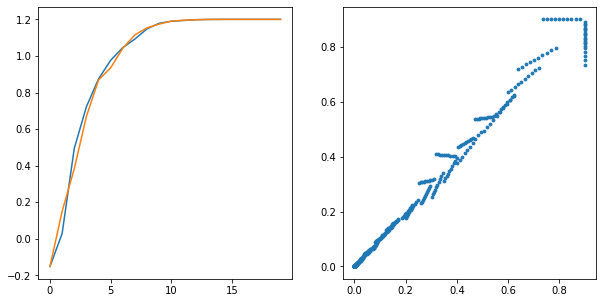

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(fitness_log)
axs[1].scatter(theta_log[:, 0], theta_log[:, 1], s=8)